In [1]:
# importing
import numpy as np
import gzip, os
from urllib.request import urlretrieve
from random import random
from math import exp
from random import seed
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pdb

Now testing to see if we can detect objects within an image

This is the actual semantic segmentation part

In [2]:
## DATA HERE from PASCAL2

import os
import tarfile
import shutil
import urllib.request

url='http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar'
path='VOC'
def get_archive(path,url):
  try:
    os.mkdir(path)
  except:
    path=path

  filename='devkit'
  urllib.request.urlretrieve(url,f"{path}/{filename}.tar")

get_archive(path,url)
def extract(path):
  tar_file=tarfile.open(f"{path}/devkit.tar")
  tar_file.extractall('./')
  tar_file.close()
  shutil.rmtree(path)

extract(path)

In [3]:
from PIL import Image
import matplotlib.pyplot as plt
import torch
from torchvision import models
import torchvision.transforms as T
import numpy as np


# color (rgb) segmentation maps in the dataset, change to single number in training
VOC_COLORMAP = [
    [0, 0, 0],
    [224, 224, 192],
    [128, 0, 0],
    [0, 128, 0],
    [128, 128, 0],
    [0, 0, 128],
    [128, 0, 128],
    [0, 128, 128],
    [128, 128, 128],
    [64, 0, 0],
    [192, 0, 0],
    [64, 128, 0],
    [192, 128, 0],
    [64, 0, 128],
    [192, 0, 128],
    [64, 128, 128],
    [0, 64, 0],
    [192, 128, 128],
    [128, 64, 0],
    [0, 192, 0],
    [128, 192, 0],
    [0, 64, 128],
]

# categories, ordering respectivley
VOC_CLASSES = [
    "background",
    "edge",
    "aeroplane",
    "bicycle",
    "bird",
    "boat",
    "bottle",
    "bus",
    "car",
    "cat",
    "chair",
    "cow",
    "diningtable",
    "dog",
    "horse",
    "motorbike",
    "potted plant",
    "person",
    "sheep",
    "sofa",
    "train",
    "tv/monitor",
]

In [4]:
import os
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class VocDataset(Dataset):
  def __init__(self, dir, color_map):
    self.root = os.path.join(dir,'VOCdevkit/VOC2007')
    self.images_dir = os.path.join(self.root,'JPEGImages')
    self.target_dir = os.path.join(self.root,'SegmentationClass') # this should be ground truth
    file_list = os.path.join(self.root,'ImageSets/Segmentation/trainval.txt')
    self.files = [line.rstrip() for line in open(file_list, "r")]
    self.color_map = color_map

  def colors_to_seg_map(self, seg_RGB):
    # return None
    seg_map = [[1 for _ in range(seg_RGB.shape[1])] for _ in range(seg_RGB.shape[0])]
    for row in range(len(seg_RGB)):
      for col in range(len(seg_RGB[0])):
        pixel = list(seg_RGB[row][col])
        if pixel not in VOC_COLORMAP:
          print("HELLO BIG PROBLEM HERE")
        id = VOC_COLORMAP.index(pixel)
        seg_map[row][col] = id
    return seg_map
    return np.array(seg_map)


    # to look at the seg maps, uncomment
    # print(f"here is the max: {np.max(seg_RGB)}")
    # seg_map = [[[0 for _ in range(seg_RGB.shape[1])] for _ in range(seg_RGB.shape[0])] for _ in range(len(VOC_COLORMAP))]
    # for row in range(len(seg_RGB)):
    #   for col in range(len(seg_RGB[0])):
    #     pixel = list(seg_RGB[row][col])
    #     id = VOC_COLORMAP.index(pixel)
    #     seg_map[id][row][col] = 1
    # # for i in range(len(seg_map)):
    # #   plt.imshow(seg_map[i])
    # #   plt.show()
    # # seg_maps = tensor(seg_maps)


  def __len__(self):
    return len(self.files)

  def __getitem__(self, index):
    file = self.files[index]
    image_path = os.path.join(self.images_dir, file + ".jpg")
    seg_path = os.path.join(self.target_dir, file + ".png")

    # Load image
    image = Image.open(image_path).convert("RGB")

    # Load segmentation map

    # center_crop = transforms.CenterCrop((224, 224))
    center_crop = transforms.Resize((224, 224), interpolation=Image.NEAREST) # resizing seems to give better results than center crop
    image = center_crop(image)

    pre_seg_RGB = Image.open(seg_path).convert("RGB")
    pre_seg_RGB = center_crop(pre_seg_RGB)
    seg_RGB = np.array(pre_seg_RGB)

    seg_map = self.colors_to_seg_map(seg_RGB)


    # old transformations based on imagenet norm
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))  # ImageNet normalization
    ])

    image = transform(image)


    return image, torch.tensor(seg_map).long()
    # return image, seg_map

In [5]:
class FCN32(torch.nn.Module):
    def __init__(self, n_classes):
        super().__init__()

        # Pretrained VGG-16 features
        vgg16 = models.vgg16(weights="VGG16_Weights.DEFAULT")
        self.features = vgg16.features

        # Extract feature maps for skip connections
        self.pool3 = nn.Sequential(*self.features[:17])  # Up to pool3
        self.pool4 = nn.Sequential(*self.features[17:24])  # Up to pool4
        self.pool5 = nn.Sequential(*self.features[24:])  # pool5 and beyond

        # Decoder for upsampling with skip connections
        self.decoder = nn.Sequential(
            # ASPP Layer (captures multi-scale context)
            nn.Conv2d(512, 512, kernel_size=3, dilation=2, padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(512),

            # Upsampling Layers
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )

        # Final Convolution
        self.final_upsample = nn.ConvTranspose2d(
            128, n_classes, kernel_size=8, stride=8, padding=0
        )

        # Skip connections (reduce channels before merging)
        self.skip_pool4 = nn.Conv2d(512, 128, kernel_size=1)
        self.skip_pool3 = nn.Conv2d(256, 128, kernel_size=1)

    def forward(self, x):
        # Extract feature maps
        pool3_out = self.pool3(x)  # Output of pool3
        pool4_out = self.pool4(pool3_out)  # Output of pool4
        pool5_out = self.pool5(pool4_out)  # Output of pool5 (used by the decoder)

        # Decoder (upsample pool5_out)
        x = self.decoder(pool5_out)

        # Add skip connections
        pool4_skip = self.skip_pool4(pool4_out)  # Reduce channels
        x = x + nn.functional.interpolate(pool4_skip, size=x.shape[2:], mode="bilinear", align_corners=False)

        pool3_skip = self.skip_pool3(pool3_out)  # Reduce channels
        x = x + nn.functional.interpolate(pool3_skip, size=x.shape[2:], mode="bilinear", align_corners=False)

        # Final upsample to match input size
        x = self.final_upsample(x)
        return x

In [6]:
class FCN32_PT(torch.nn.Module):
    def __init__(self, n_classes):
        super().__init__()

        # p_t = torchvision.models.vgg16(pretrained=True)
        p_t = torchvision.models.vgg16(weights="VGG16_Weights.DEFAULT")

        self.pt_encode = torch.nn.Sequential(*list(p_t.features.children()))

        self.convolve = torch.nn.Sequential(
            torch.nn.Conv2d(512, 4096, kernel_size=1),
            torch.nn.ReLU(inplace=True),
            torch.nn.Dropout(),
            torch.nn.Conv2d(4096, 4096, kernel_size=1),
            torch.nn.ReLU(inplace=True),
            torch.nn.Dropout(),
            torch.nn.ConvTranspose2d(4096, 512, kernel_size=3, stride=2, padding=1, output_padding=1),
            torch.nn.BatchNorm2d(512),
            torch.nn.ReLU(inplace=True),
            torch.nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1),
            torch.nn.BatchNorm2d(256),
            torch.nn.ReLU(inplace=True),
            torch.nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU(inplace=True),
            torch.nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(inplace=True),
            torch.nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(32, n_classes, kernel_size=1)
        )

    def forward(self, x):
        x = self.pt_encode(x)
        x = self.convolve(x)

        return x

In [26]:
# seg_maps
criterion = nn.CrossEntropyLoss()
# truth = torch.empty(3, dtype=torch.long).random_(5)
truth = torch.tensor([0, 0, 1, 3, 0])
pred = torch.tensor(
        [
            [10.0, 0.0, 0.0, 0.0],
            [10.0, 0.0, 0.0, 0.0],
            [0.0, 10.0, 0.0, 0.0],
            [0.0, 0.0, 0.0, 10.0],
            [10.0, 0.0, 0.0, 0.0]
        ]
    )

print(truth)
print(pred)

output = criterion(pred, truth)
output.item()

tensor([0, 0, 1, 3, 0])
tensor([[10.,  0.,  0.,  0.],
        [10.,  0.,  0.,  0.],
        [ 0., 10.,  0.,  0.],
        [ 0.,  0.,  0., 10.],
        [10.,  0.,  0.,  0.]])


0.00013624693383462727

In [15]:
import torch.optim as optim


# Define the VOC dataset
batch_size = 32
trainset = VocDataset(dir='./', color_map=VOC_COLORMAP)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)

# FCN-32 model
fcn32_model = FCN32(n_classes=len(VOC_CLASSES))
# fcn32_model = FCN32_PT(n_classes=len(VOC_CLASSES))

# google colab gpu if we can
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
fcn32_model.to(device)

noise_layer = None

class_weights = torch.tensor([0.25, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3])
# Note the class weights, because our images are background dominant, I will punish the model more when it misclassifies anything as background
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(fcn32_model.parameters(), lr=0.001)

torch.autograd.set_detect_anomaly(True)

epochs = 50
for epoch in range(epochs):  # loop over the dataset multiple times
    print(f"epoch {epoch}")
    running_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        # print(f"iteration {i}")
        # pdb.set_trace()
        # assert False
        inputs, seg_maps = data

        # Move inputs and segmentation maps to GPU if available
        inputs, seg_maps = inputs.to(device), seg_maps.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = fcn32_model(inputs)

        # predicted_classes = torch.argmax(outputs, dim=1)
        # print(f"inputs size: {inputs.size()}")
        # print(f"outputs size: {outputs.size()}")
        # print(f"predicted_classes size: {predicted_classes.size()}")
        # print(f"seg_maps size: {seg_maps.size()}")

        # print(f"segmap max: {torch.max(seg_maps[0])}")
        # print(f"segmap min: {torch.min(seg_maps[0])}")
        # final = [[[255 for _ in range(3)] for _ in range(224)] for _ in range(224)]
        # for row in range(224):
        #     for col in range(224):
        #         final[row][col] = VOC_COLORMAP[seg_maps[0][row][col]]
        # plt.imshow(final)
        # plt.show()

        loss = criterion(outputs, seg_maps)
        # loss = criterion(predicted_classes, seg_maps.float())

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
        if i % 10 == 0 and i != 0:    # Print every 200 mini-batches
            print(f'Epoch [{epoch + 1}/{epochs}], Batch [{i + 1}/{len(trainloader)}], Loss: {running_loss / 10:.4f}')
            running_loss = 0.0

print('Finished Training')


epoch 0
Epoch [1/50], Batch [11/14], Loss: 3.2246
epoch 1
Epoch [2/50], Batch [11/14], Loss: 2.9881
epoch 2
Epoch [3/50], Batch [11/14], Loss: 2.9440
epoch 3
Epoch [4/50], Batch [11/14], Loss: 2.7939
epoch 4
Epoch [5/50], Batch [11/14], Loss: 2.7461
epoch 5
Epoch [6/50], Batch [11/14], Loss: 2.6648
epoch 6
Epoch [7/50], Batch [11/14], Loss: 2.5886
epoch 7
Epoch [8/50], Batch [11/14], Loss: 2.6114
epoch 8
Epoch [9/50], Batch [11/14], Loss: 2.6097
epoch 9
Epoch [10/50], Batch [11/14], Loss: 2.5073
epoch 10
Epoch [11/50], Batch [11/14], Loss: 2.3953
epoch 11
Epoch [12/50], Batch [11/14], Loss: 2.3693
epoch 12
Epoch [13/50], Batch [11/14], Loss: 2.4653
epoch 13
Epoch [14/50], Batch [11/14], Loss: 2.3463
epoch 14
Epoch [15/50], Batch [11/14], Loss: 2.3305
epoch 15
Epoch [16/50], Batch [11/14], Loss: 2.2656
epoch 16
Epoch [17/50], Batch [11/14], Loss: 2.2093
epoch 17
Epoch [18/50], Batch [11/14], Loss: 2.1836
epoch 18
Epoch [19/50], Batch [11/14], Loss: 2.1431
epoch 19
Epoch [20/50], Batch [

In [16]:
torch.save(fcn32_model.state_dict(), "fcn32_model_30_32_batch.pth")
print("Model saved to fcn32_model.pth")

Model saved to fcn32_model.pth


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


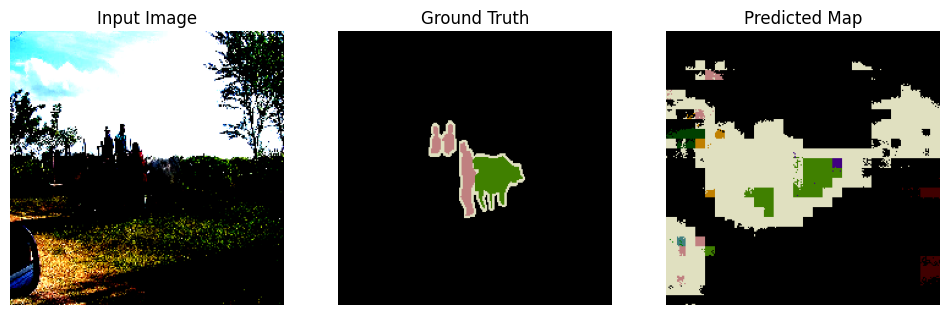

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


CALCULATED IOU: 0.2676379145408163


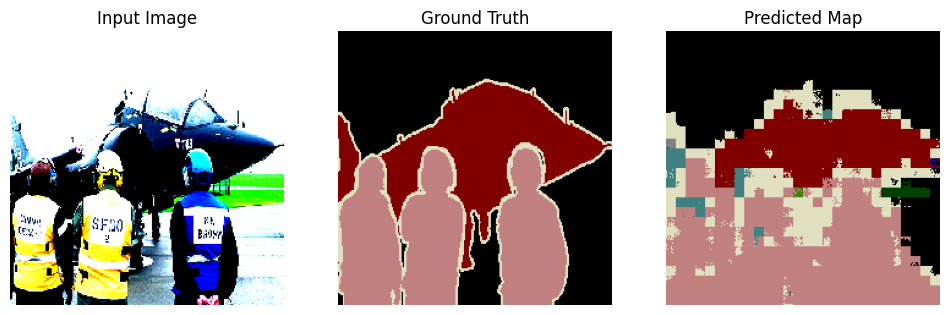

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0665298..2.64].


CALCULATED IOU: 0.27736367984693877


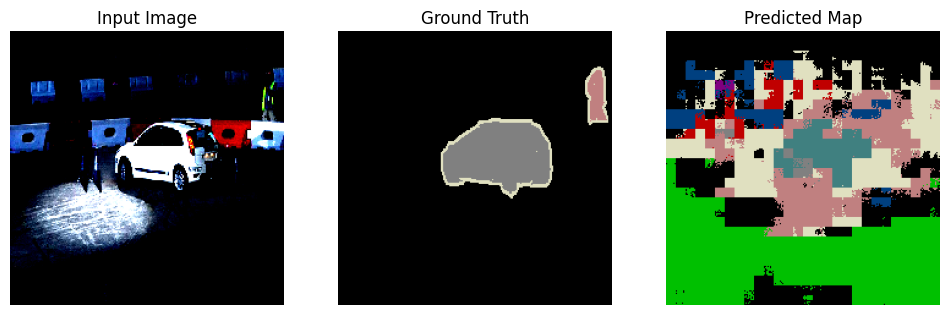

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5528543].


CALCULATED IOU: 0.6838129783163265


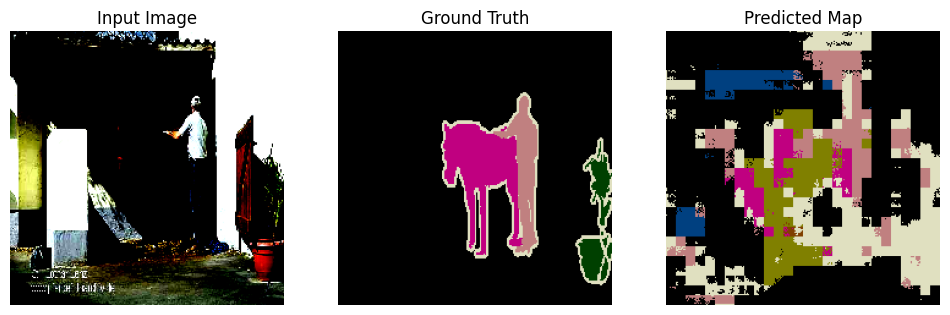

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.3235295].


CALCULATED IOU: 0.389827806122449


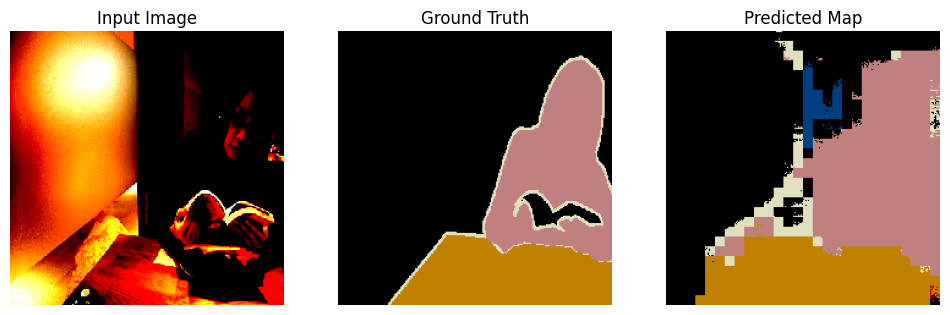

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


CALCULATED IOU: 0.19770408163265307


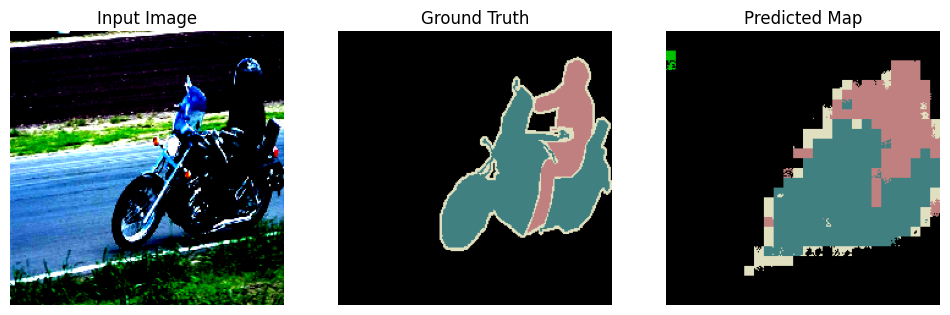

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


CALCULATED IOU: 0.1464245854591837


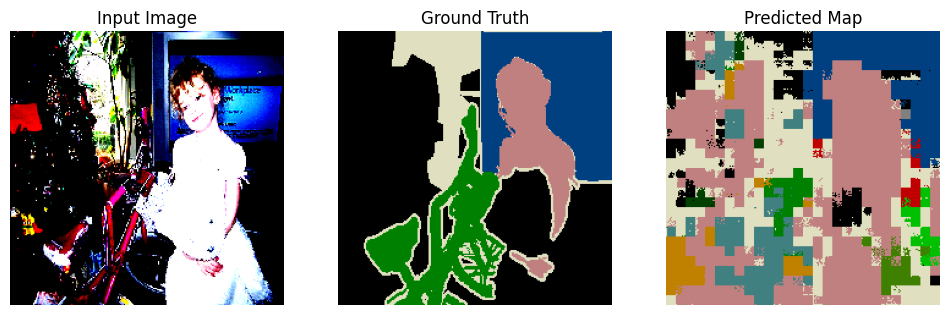

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.4285715].


CALCULATED IOU: 0.6629862882653061


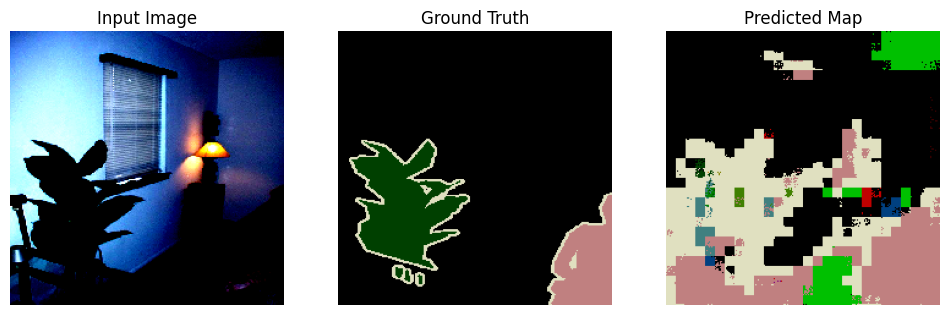

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9295317..2.2914162].


CALCULATED IOU: 0.4192044005102041


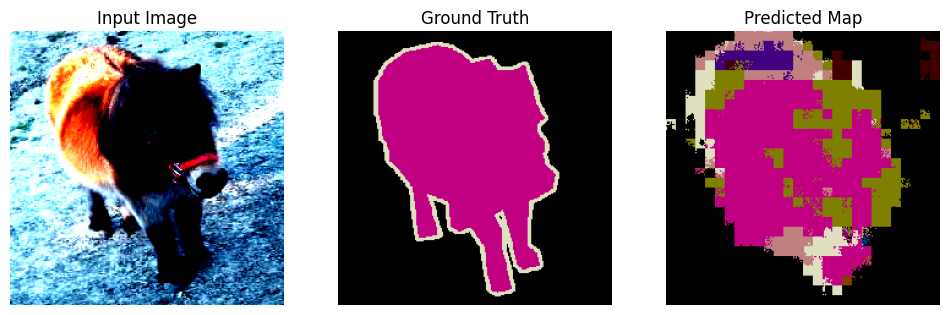

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


CALCULATED IOU: 0.29976482780612246


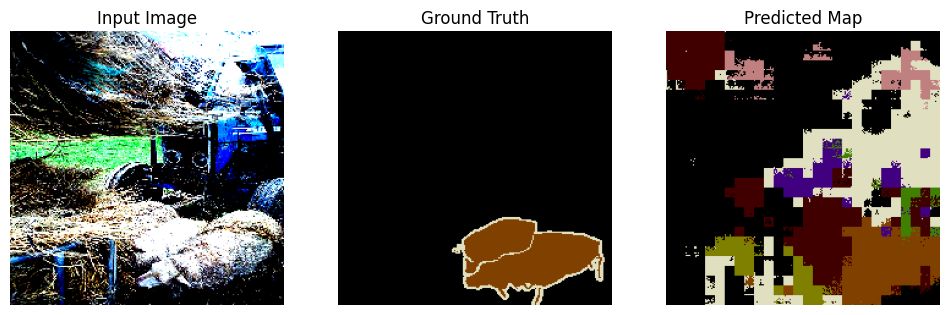

CALCULATED IOU: 0.4748684630102041
The mean iou across 10 sample images is 0.3819595025510204.


In [17]:
# Define the test dataset
testset = VocDataset(dir='./', color_map=VOC_COLORMAP)
testloader = DataLoader(testset, batch_size=1, shuffle=True)

# Define a function to calculate IoU
def calculate_iou(pred, target):
  total_pix = len(pred) * len(pred[0])
  errors = 0
  for i in range(len(pred)):
    for j in range(len(pred[0])):
      if (pred[i][j] != target[i][j]):
        errors += 1
  return errors / total_pix

def collapse(detensor):
  # seg_map is like this [[[0 for _ in range(seg_RGB.shape[1])] for _ in range(seg_RGB.shape[0])] for _ in range(len(VOC_COLORMAP))]
  final = [[[255 for _ in range(3)] for _ in range(224)] for _ in range(224)]
  len_detensor = len(detensor)

  for row in range(224):
    for col in range(224):
      max_prob = -1.0
      max_layer = -1.0
      for layer_i in range(len_detensor):
        # print(f"checking layer {layer_i}")
        pixel = detensor[layer_i][row][col]
        # print(f"probability {pixel} found on layer {layer_i}")
        if pixel > max_prob:
          max_prob = pixel
          max_layer = layer_i
      # print(f"max layer selected: {max_layer}")
      final[row][col] = VOC_COLORMAP[max_layer]

  return final

def seg_map_format(seg_map):
  final = [[[255 for _ in range(3)] for _ in range(224)] for _ in range(224)]
  for row in range(224):
    for col in range(224):
      final[row][col] = VOC_COLORMAP[seg_map[row][col]]
  return final

def seg_map_format(seg_map):
  final = [[[255 for _ in range(3)] for _ in range(224)] for _ in range(224)]
  for row in range(224):
    for col in range(224):
      final[row][col] = VOC_COLORMAP[seg_map[row][col]]
  return final


# Initialize lists to store input images, segmentation maps, and predicted maps
input_images = []
ground_truths = []
predicted_maps = []
list_for_iou = []

counter = 0

# Perform inference
fcn32_model.eval()  # Set model to evaluation mode
with torch.no_grad():  # Disable gradient calculation
    for images, seg_maps in testloader:
        # Move images and segmentation maps to GPU if available
        images, seg_maps = images.to(device), seg_maps.to(device)

        # Run model inference
        outputs = fcn32_model(images)
        # print(outputs.size())
        # print(outputs[0])
        # assert False

        # Get predicted class indices
        pred_indices = torch.argmax(outputs, dim=1)
        # print(np.average(pred_indices.cpu().numpy()))

        # Convert predicted indices to segmentation maps
        # predicted_maps.append(pred_indices.cpu().numpy())
        # predicted_maps.append(final)
        predicted_maps.append(seg_map_format(pred_indices[0]))

        # Store input images and ground truth segmentation maps
        input_images.append(images[0].cpu().numpy())
        ground_truths.append(seg_map_format(seg_maps[0].cpu().numpy()))

        list_for_iou.append((pred_indices[0], seg_maps[0].cpu().numpy()))

        # break
        counter = counter + 1
        if counter == 10:
          break


# Visualize the results
import matplotlib.pyplot as plt
running_iou = 0.0

# input, truth, and prediction
def visualize_result(image, gt, pred, idx, iou_p):
  global running_iou
  plt.figure(figsize=(12, 4))

  # Input
  plt.subplot(1, 3, 1)
  plt.imshow(image.transpose(1, 2, 0))
  plt.title("Input Image")
  plt.axis('off')

  # Ground
  plt.subplot(1, 3, 2)
  plt.imshow(gt, vmin=0, vmax=len(VOC_CLASSES)-1)
  plt.title("Ground Truth")
  plt.axis('off')

  # Predicted
  plt.subplot(1, 3, 3)
  plt.imshow(pred, vmin=0, vmax=len(VOC_CLASSES)-1)
  plt.title("Predicted Map")
  plt.axis('off')

  plt.show()

  iou = calculate_iou(iou_p[0], iou_p[1])
  print(f"CALCULATED IOU: {iou}")
  running_iou += iou


# Visualize a random sample of the results
for i in range(counter):
  visualize_result(input_images[i], ground_truths[i], predicted_maps[i], i, list_for_iou[i])

print(f"The mean iou across {counter} sample images is {running_iou / counter}.")